In [1]:
%matplotlib inline
from joblib import load
from ruamel.yaml import YAML
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import h5py

from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold, GridSearchCV, ShuffleSplit, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.gaussian_process import GaussianProcessRegressor, kernels
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, BayesianRidge, Ridge
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.utils import resample

from umda import paths

In [2]:
seed = 1215677
normalize = False
mask = False

In [3]:
def load_data(exclude_hydrogen: bool=True):
    data_path = paths.get("processed").joinpath("pipeline_embeddings_70.h5")
    tmc1_data = pd.read_pickle(paths.get("processed").joinpath("tmc1_ready.pkl"))
    if exclude_hydrogen:
        tmc1_data = tmc1_data.loc[tmc1_data["SMILES"] != "[HH]"]
    tmc1_data.reset_index(inplace=True, drop=True)
    with h5py.File(data_path, "r") as h5_data:
        X = h5_data["pca"][:]
        cluster_ids = h5_data["cluster_ids"][:]
    return X, cluster_ids, tmc1_data


def load_pipeline():
    model_path = paths.get("models")
    embedder = load(model_path.joinpath("EmbeddingModel.pkl"))
    return embedder


def cross_validation(data, estimator, hparams, seed, n_splits: int = 5, n_jobs: int = 16):
    X, y = data
    splitter = ShuffleSplit(n_splits, random_state=seed)
    grid_search = GridSearchCV(
        estimator,
        {f"regressor__{key}": value for key, value in hparams.items()},
        scoring="r2",
        cv=splitter,
        n_jobs=n_jobs,
        refit=False
    )
    result = grid_search.fit(X, y)
    return result


def standardized_fit_test(data, estimator, hparams, seed, n_splits: int = 100, test_size: float = 0.2):
    X, y = data
    splitter = ShuffleSplit(n_splits, test_size=test_size, random_state=seed)
    best_train_error, best_test_error, best_combined = np.inf, np.inf, np.inf
    log = list()
    for split_index, (train_index, test_index) in enumerate(splitter.split(X, y)):
        train_X, test_X, train_y, test_y = X[train_index], X[test_index], y[train_index], y[test_index]
        # current_estimator = estimator.__class__()
        # set the estimator hyperparameters
        estimator.__dict__.update(**{f"regressor__{key}": value for key, value in hparams.items()})
        result = estimator.fit(train_X, train_y)
        # compute the mean squared error
        train_error = mean_squared_error(train_y, result.predict(train_X))
        test_error = mean_squared_error(test_y, result.predict(test_X))
        combined_error = mean_squared_error(y, result.predict(X))
        r2 = r2_score(y, result.predict(X))
        log.append({"train_error": train_error, "test_error": test_error, "combined_error": combined_error, "r2": r2, "train_index": train_index, "test_index": test_index})
        if test_error < best_test_error:
            best_split = (train_index, test_index)
            best_train_error = train_error
            best_test_error = test_error
            best_combined = combined_error
            best_estimator = result
    return best_estimator, best_train_error, best_test_error, best_split, log


def compose_model(base_estimator, scale: bool = False):
    if scale:
        models = [
            ("scaler", StandardScaler()), ("regressor", base_estimator)
        ]
    else:
        models = [("regressor", base_estimator)]
    return Pipeline(models)

In [606]:
state = np.random.default_rng(seed)

full_X, full_cluster_ids, tmc1_df = load_data()
embedder = load_pipeline()

tmc1_X = np.vstack([embedder.vectorize(smi) for smi in tmc1_df["SMILES"]])
tmc1_y = np.log10(tmc1_df["Column density (cm^-2)"].to_numpy())

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator StandardScaler from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator IncrementalPCA from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator KMeans from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/base.py:315: UserWarning: Trying to unpickle estimator Pipeline from version 0.23.2 when using version 0.24

In [662]:
with open("model_hparams.yml") as read_file:
    hparams = YAML().load(read_file)

In [663]:
gp_kernel = kernels.ConstantKernel() * \
    kernels.RBF(3.0, (1e-1, 10.0)) + \
    kernels.RationalQuadratic(200.0, 20.0, alpha_bounds=(1e-3, 5e2), length_scale_bounds=(50.0, 1e4)) * \
        kernels.ConstantKernel() + kernels.ConstantKernel()

In [664]:
base_models = {
    "linear_regression": LinearRegression(),
    "ridge": Ridge(),
    "svr": SVR(),
    "br": BayesianRidge(),
    "knn": KNeighborsRegressor(),
    "rfr": RandomForestRegressor(random_state=seed),
    "gbr": GradientBoostingRegressor(random_state=seed),
    "gpr": GaussianProcessRegressor(
        kernel=gp_kernel, random_state=seed
    )
}

models = {key: compose_model(value, normalize) for key, value in base_models.items()}

In [665]:
# generalized workflow
model_results = dict()
best_models = dict()
cv_results = dict()
for name in models.keys():
    model = models.get(name)
    hparam = hparams.get(name)
    cv_grid = cross_validation((tmc1_X, tmc1_y), model, hparam, seed)
    print(f"Model: {name} best CV score: {cv_grid.best_score_:.4e}")
    best_estimator, best_train, best_test, best_index, log = standardized_fit_test((tmc1_X, tmc1_y), model, cv_grid.best_params_, seed, n_splits=20)
    model_results[name] = log
    best_models[name] = best_estimator
    cv_results[name] = cv_grid

/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:289: UserWarning: The total space of parameters 2 is smaller than n_iter=10. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
Model: linear_regression best CV score: -5.4218e+13
Model: ridge best CV score: -1.2134e+00
Model: svr best CV score: -1.2826e-01
Model: br best CV score: -1.2749e+00
Model: knn best CV score: -6.6063e-02
Model: rfr best CV score: -2.3436e-02
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One or more of the test scores are non-finite: [-0.14915524 -0.14372437 -0.15232949 -0.11310683 -0.14701598 -0.15820126
 -0.15368787         nan -0.14675171 -0.146141  ]
  category=UserWarning
Model: gbr best CV score: -1.1311e-01
/home/kelvin/miniconda3/envs/umda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:921: UserWarning: One

In [611]:
# export the cross-validation results
for name in models.keys():
    df = pd.DataFrame(cv_results[name].cv_results_)
    keys = ["mean_test_score", "rank_test_score"]
    keys.extend([key for key in df.keys() if "param_" in key])
    df = df[keys]
    # sort and reset the indices
    df.sort_values("rank_test_score", ascending=True, inplace=True)
    df.reset_index(inplace=True, drop=True)
    # dump to CSV file
    if normalize:
        flags = "norm"
    else:
        flags = "unnorm"
    if mask:
        flags += "_mask"
    else:
        flags += "_nomask"
    df.to_csv(f"outputs/grid_search/{name}_{flags}.csv", index=False)

In [666]:
cv_results["svr"].best_params_

{'regressor__kernel': 'rbf',
 'regressor__gamma': 0.05,
 'regressor__epsilon': 0.5,
 'regressor__C': 50}

In [669]:
pd.DataFrame(model_results["svr"]).sort_values(["r2", "combined_error"], ascending=[False, True])

,train_error,test_error,combined_error,r2,train_index,test_index
19,0.847580,0.652768,0.807274,0.186440,"[27, 22, 76, 1, 7, 49, 8, 64, 86, 79, 26, 50, ...","[10, 19, 71, 63, 84, 16, 32, 67, 20, 43, 57, 4..."
16,0.848213,0.661877,0.809661,0.184035,"[13, 86, 10, 54, 27, 60, 17, 52, 74, 43, 48, 1...","[28, 75, 67, 11, 42, 64, 2, 8, 20, 83, 82, 80,..."
0,0.882160,0.538300,0.811016,0.182669,"[48, 59, 11, 71, 38, 30, 56, 58, 3, 43, 29, 81...","[68, 32, 2, 69, 42, 60, 77, 0, 33, 84, 52, 15,..."
13,0.868070,0.600848,0.812783,0.180889,"[10, 75, 37, 43, 16, 25, 24, 1, 30, 11, 85, 20...","[60, 26, 65, 83, 53, 23, 27, 32, 54, 21, 78, 5..."
1,0.801862,0.906220,0.823453,0.170135,"[10, 47, 79, 58, 23, 86, 21, 68, 32, 7, 60, 27...","[70, 33, 36, 42, 4, 71, 69, 20, 19, 53, 26, 29..."
7,0.844760,0.772525,0.829815,0.163724,"[17, 3, 40, 70, 83, 53, 44, 21, 57, 20, 34, 36...","[81, 8, 43, 75, 18, 61, 32, 64, 10, 84, 28, 29..."
4,0.908982,0.538758,0.832384,0.161135,"[74, 76, 52, 51, 6, 3, 30, 49, 16, 38, 41, 53,...","[71, 4, 77, 28, 73, 23, 83, 62, 34, 81, 46, 56..."
15,0.845774,0.788861,0.833999,0.159507,"[24, 76, 15, 29, 39, 68, 63, 75, 27, 5, 74, 43...","[45, 19, 69, 1, 78, 31, 60, 44, 33, 72, 57, 12..."
6,0.835174,0.829693,0.834040,0.159466,"[51, 45, 40, 70, 52, 72, 73, 38, 82, 53, 55, 6...","[19, 26, 11, 46, 76, 50, 22, 65, 15, 41, 47, 7..."
18,0.841129,0.807617,0.834196,0.159309,"[48, 59, 41, 42, 7, 3, 53, 75, 39, 81, 52, 70,...","[73, 0, 17, 6, 47, 2, 56, 68, 9, 78, 54, 5, 82..."


[(10.0, 15.0), (10.0, 15.0)]

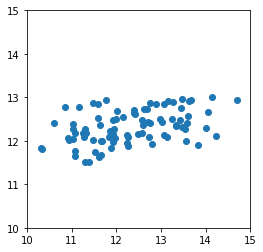

In [670]:
fig, ax = plt.subplots(figsize=(4,4))

ax.scatter(tmc1_y, best_models["svr"].predict(tmc1_X))
ax.set(xlim=[10., 15.], ylim=[10., 15.])

## Data importance estimation

In [599]:
def bootstrap_importance_estimation(estimator, data, seed: int, n_splits: int = 500):
    X, y = data
    splitter = ShuffleSplit(n_splits, test_size=0.2, random_state=seed)
    log = list()
    weights = np.ones((n_splits, y.size))
    test_errors = list()
    for split_index, (train_index, test_index) in enumerate(splitter.split(X, y)):
        train_X, test_X, train_y, test_y = X[train_index], X[test_index], y[train_index], y[test_index]
        result = estimator.fit(train_X, train_y)
        # compute the mean squared error
        train_error = mean_squared_error(train_y, result.predict(train_X))
        test_error = mean_squared_error(test_y, result.predict(test_X))
        log.append(
            {"train_error": train_error, "test_error": test_error, "train_index": train_index, "test_index": test_index}
        )
        test_errors.append(test_error)
        weights[split_index, test_index] = 0.
    # reshape so we can do matrix multiplication
    test_errors = np.asarray(test_errors)[:,None]
    molecule_weights = (weights * test_errors).std(axis=0)
    molecule_weights /= np.min(molecule_weights)
    return log, molecule_weights

In [600]:
bootstrap_log, weights = bootstrap_importance_estimation(best_models["ridge"], (tmc1_X, tmc1_y) ,seed, n_splits=5000)